<h1>Import libraries<h1>

In [1]:
from Model.Ada_Boost_Classifier_from_scratch import *
from Model.Ada_Boost_Regressor_from_scratch import *
from Model.Ada_Boost_optimization import *
from Metrics.Classification_metrics import *
from Metrics.Regression_metrics import *
from Plots.Prediction_plots import *
Plots_predictions = Prediction_plots()

<h1>Explanation of AdaBoost<h1>

$\text{AdaBoost (Adaptive Boosting) is an algorithm that can be used for both regression and classification problems.}$<p>
$\text{In this case, boosting involves weighting the training dataset, placing more emphasis on observations for which previous estimators made an error.}$<p>

<h2>Construction of AdaBoost<h2>

$1. \text{ Determining T - the number of estimators.}$<p><br>
$2. \text{ Determining the initial weights for each observation: }$
$$w_i=\frac{1}{N}$$
$\text{ Where: } N \text{ - the number of observations in the training set.}$<p><br>
$3. \ for \ t=1 \ to \ T:$<p>
$\text{a) Training the estimator: } Estimator_t \text{ using the current weights.}$<p>
$\text{b) Determining the error for a given estimator:}$
$$Error_t=\frac{\sum_{i=1}^{N}{w_i\times L o s s(y_i,prediction_i)}}{\sum_{i=1}^{N}w_i}$$
$\text{Where: } N \text{ - number of observations in the training set,}$<p>
$w_i \text{ - weight for observation }i,$<p>
$y_i \text{ - the value of the explanatory variable for observation }i,$<p>
$prediction_i \text{ - } Estimator_t \text{ prediction for observation }i,$<p>
$Loss(y_i,prediction_i) \text{ - loss function. In the case of a classification problem, it is: 1 } y_i\neq prediction_i \text{ and 0 for } y_i=prediction_i.$<p>
$\text{For regression, it can be:}$<p>
$− `linear`: \left|y_i-prediction_i\right|,$<p>
$− `square`: {(y_i-prediction_i)}^2,$<p>
$− `exponential`: 1-e^{-y_i\times prediction_i}$<p>
$\text{c) Calculation of weights for } Estimator_t:$<p>
$$\alpha_t=learning\_rate\times\frac{1}{2}\times\log{\left(\frac{1-Error_t}{Error_t}\right)}$$
$\text{Where: } learning\_rate \text{ - constant.}$<p>
$\text{d) Determination of new sample weights:}$<p>
$$w_i=w_{i,\ old}\times e^{\alpha_t\times Loss\left(y_i,prediction_i\right)}$$
$\text{e) Normalize the weights so that their sum equals to 1:}$<p>
$$w_i=\frac{w_i-\min{\left(w\right)}}{\max{\left(w\right)}-\min{\left(w\right)}}$$
$4. \text{Determination of predictions:}$<p>
$$Predictions=\begin{cases}
                \operatorname*{arg\,max}_k \ \sum_{t=1}^{T}{\alpha_t\times\mathbb{I}\left({Estimator}_t\left(X\right)=k\right)}\rightarrow Classification \\ 
                Median\ Estimator\left(X\right) \rightarrow Regression
               \end{cases}$$

<h3>Median estimator in regression<h3>

$\text{- We sort the prediction values by creating a list with the indexes of these values } (sorted\_idx).$<p><br>
$\text{- Each prediction was determined by any of the estimators, so we check which estimators were responsible for the selected predictions.}$<p>
$\text{To do this, we use the indexes of these prediction values and create a list } (sorted\_weights) \text{ with the corresponding weights of the estimators.}$<p><br>
$\text{- We create a list } (cumulate\_weights) \text{ with the cumulative weights of the estimators.}$<p><br>
$\text{- We determine an index } (median\_estimator\_idx) \text{ equal to the first value in the list of } cumulate\_weights \text{ satisfying the condition: }$
$$cumulate\_weights\geq\frac{\max{\left(cumulate\_weights\right)}}{2}$$
$\text{The above procedure ensures that even if the estimators with higher weights appeared at the beginning (they returned predictions with the lowest values), any of them could still potentially be finally selected.}$<p><br>
$\text{- We determine the median estimator using the sorted list and } median\_estimator\_idx.$<p><br>
$\text{- The prediction of this estimator is the prediction returned by AdaBoost Regressor.}$

<h1>Preprocessing<h1>

<h2>Download data<h2>

In [28]:
data = pd.read_csv("Data/bank-balanced.csv")
X = data.drop("deposit", axis=1)
y = data["deposit"]

In [29]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 11162


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


<h2>Check for null data<h2>

In [30]:
data.isnull().sum()/len(data)

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
deposit      0.0
dtype: float64

<h2>Convert object to numeric<h2>

$\text{For AdaBoost we have to convert object/string features to numeric.}$<p>
$\text{For AdaBoost, the best option would be to use OridinalEncoding instead of OneHotEncoding because of that algorithm's problem with the curse of dimensionality}$

In [31]:
list_of_object_features_classification = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features_classification = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features_classification] = encoder.fit_transform(data[list_of_object_features_classification])

<h2>Divide our data into train and test sets<h2>

In [32]:
target_binary = "deposit"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

$\text{The huge advantage of Ada Boost compared to other popular algorithms is that there is no need to scale the data.}$

<h1>Evaluation and Visualization<h1>

$\text{To verify how well our algorithms are able to perform, a cross-validation will be used on the training set (in order to average the results obtained).}$<p>
$\text{Then we will check whether the algorithms will perform equally well (or even better) on the test data.}$

In [33]:
class Cross_Validation():
    def __init__(self, metric, algorithm_instance, cross_validation_instance):
        metrics = {"accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds"],
                    "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs"],
                    "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds"],
                    "rmse": [lambda y, y_pred: mean_squared_error(y, y_pred)**0.5, "preds"],
                    "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds"]}
        if metric not in metrics:
            raise ValueError('Unsupported metric: {}'.format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.algorithm = algorithm_instance
        self.cv = cross_validation_instance
    
    def fit(self, X, y, verbose=False):
        X = self.check_X(X=X)
        y = self.check_y(y=y)
        self.train_scores, self.valid_scores = [], []
        for iter, (train_idx, valid_idx) in enumerate(self.cv.split(X, y)):
            X_train, X_valid = X[train_idx, :], X[valid_idx, :]
            y_train, y_valid = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train, y_train)
            if(self.metric_type == "preds"):
                y_train_pred = self.algorithm.predict(X_train)
                y_valid_pred = self.algorithm.predict(X_valid)
            else:
                y_train_pred = self.algorithm.predict_proba(X_train)[:, 1]
                y_valid_pred = self.algorithm.predict_proba(X_valid)[:, 1]
            self.train_scores.append(self.eval_metric(y_train, y_train_pred))
            self.valid_scores.append(self.eval_metric(y_valid, y_valid_pred))
            if(verbose == True):
                print("Iter {}: train scores: {}; valid scores: {}".format(iter, np.round(self.eval_metric(y_train, y_train_pred), 5), np.round(self.eval_metric(y_valid, y_valid_pred), 5)))
        return np.mean(self.train_scores), np.mean(self.valid_scores)
    
    def check_X(self, X):
        if not isinstance(X, pd.DataFrame) and not isinstance(X, np.ndarray) and not torch.is_tensor(X):
            raise TypeError('Wrong type of X. It should be dataframe, numpy array or torch tensor.')
        X = np.array(X)
        if(X.ndim == 1):
            X = X[None, :]
        return X
    
    def check_y(self, y):
        if not isinstance(y, pd.DataFrame) and not isinstance(y, pd.Series) and not isinstance(y, np.ndarray) and not torch.is_tensor(y):
            raise TypeError('Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array or torch tensor.')
        y = np.array(y)
        if(y.ndim == 2):
            y = y.squeeze()
        return y

In [34]:
model = Ada_Boost_Classifier(n_estimators=50, learning_rate=1.0, random_state=17)
CV = Cross_Validation(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=True)
print("Mean of train scores: {}; Mean of valid scores: {}".format(np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

Iter 0: train scores: 0.90201; valid scores: 0.89116
Iter 1: train scores: 0.90225; valid scores: 0.8969
Iter 2: train scores: 0.90196; valid scores: 0.90306
Iter 3: train scores: 0.90063; valid scores: 0.88491
Iter 4: train scores: 0.90347; valid scores: 0.89624
Mean of train scores: 0.90206; Mean of valid scores: 0.89445


$\text{As we can see our algorithm performs really well on training and validation dataset.}$

$\text{Check the results for original test dataset.}$

In [35]:
model = Ada_Boost_Classifier(n_estimators=50, learning_rate=1.0, random_state=17)
model.fit(X_train, y_train)
y_prob_train = model.predict_proba(X_train)[:,1]
y_prob_test = model.predict_proba(X_test)[:,1]
print("AdaBoost Classifier: Train: {}; Test: {}".format(np.round(roc_auc_score(y_train, y_prob_train), 4), np.round(roc_auc_score(y_test, y_prob_test), 4)))

AdaBoost Classifier: Train: 0.9045; Test: 0.899


$\text{Write down predictions for the future}$

In [36]:
base_predictions = model.predict(X_test)
base_probabilities = model.predict_proba(X_test)[:, 1]

$\text{We will try to tune hyperparameters to see whether we can improve accuracy.}$

<h1>Optimization<h1>

$\text{There are not many parameters in AdaBoost that we can tune, but let's start with } estimator.$<p>
$\text{In AdaBoost we are able to use various weak learners.}$<p>
$\text{We will check which one is the best from: [Decision Tree, Logistic Regression, GaussianNB].}$

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
model = AdaBoostClassifier(random_state=17)
CV = Cross_Validation_Ada_Boost_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for estimator in [DecisionTreeClassifier(max_depth=1, random_state=17), LogisticRegression(random_state=17, max_iter=1000), GaussianNB()]:
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, estimator=estimator)
    print("estimator: {}; Mean of train scores: {}; Mean of valid scores: {}".format(estimator, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

estimator: DecisionTreeClassifier(max_depth=1, random_state=17); Mean of train scores: 0.90492; Mean of valid scores: 0.89479
estimator: LogisticRegression(max_iter=1000, random_state=17); Mean of train scores: 0.86165; Mean of valid scores: 0.86034
estimator: GaussianNB(); Mean of train scores: 0.71424; Mean of valid scores: 0.71077


$\text{Best base estimator is DecisionTree.}$

$n\_estimators \ [int] \text{: specifying the number of estimators used in building the AdaBoost.}$<p>
$\text{A larger number of estimators reduces the likelihood of overfitting (better averaging/more models considered for voting)}$<p>
$\text{On the other hand, larger number of estimators leads to more models to train, i.e. longer compilation time.}$<p>
$\text{As a rule, a value of 50 should be sufficient, but an optimal value can be found through cross-validation.}$

In [38]:
model = AdaBoostClassifier(random_state=17, estimator=DecisionTreeClassifier(max_depth=1, random_state=17))
CV = Cross_Validation_Ada_Boost_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for n_estimators in range(10, 800, 50):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, n_estimators=n_estimators)
    print("n_estimators: {}; Mean of train scores: {}; Mean of valid scores: {}".format(n_estimators, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

n_estimators: 10; Mean of train scores: 0.86869; Mean of valid scores: 0.86113
n_estimators: 60; Mean of train scores: 0.90723; Mean of valid scores: 0.89666
n_estimators: 110; Mean of train scores: 0.91289; Mean of valid scores: 0.9
n_estimators: 160; Mean of train scores: 0.91573; Mean of valid scores: 0.90138
n_estimators: 210; Mean of train scores: 0.91783; Mean of valid scores: 0.90228
n_estimators: 260; Mean of train scores: 0.91948; Mean of valid scores: 0.90225
n_estimators: 310; Mean of train scores: 0.92086; Mean of valid scores: 0.90256
n_estimators: 360; Mean of train scores: 0.92184; Mean of valid scores: 0.90311
n_estimators: 410; Mean of train scores: 0.92283; Mean of valid scores: 0.90295
n_estimators: 460; Mean of train scores: 0.92356; Mean of valid scores: 0.90305
n_estimators: 510; Mean of train scores: 0.92434; Mean of valid scores: 0.9025
n_estimators: 560; Mean of train scores: 0.92496; Mean of valid scores: 0.90213
n_estimators: 610; Mean of train scores: 0.9255

$\text{We see that as we increase the number of estimators in the AdaBoost, our algorithm gets better results.}$<p>
$\text{However, from the level of } n\_estimators=350 \text{ we can see a exacerbation, for this reason value of 350 will be used in further optimization.}$

$learning\_rate \ [float]: \text{ controls the loss function used for calculating the weight of the estimators.}$

In [39]:
model = AdaBoostClassifier(random_state=17, estimator=DecisionTreeClassifier(max_depth=1, random_state=17), n_estimators=350)
CV = Cross_Validation_Ada_Boost_optimization(metric="roc_auc", algorithm_instance=model, cross_validation_instance=KFold(n_splits=5, shuffle=True, random_state=17))
for learning_rate in np.linspace(0.01, 1.5, 10):
    mean_of_train_scores, mean_of_valid_scores = CV.fit(X=X_train, y=y_train, verbose=False, learning_rate=learning_rate)
    print("learning_rate: {}; Mean of train scores: {}; Mean of valid scores: {}".format(learning_rate, np.round(mean_of_train_scores, 5), np.round(mean_of_valid_scores, 5)))

learning_rate: 0.01; Mean of train scores: 0.86256; Mean of valid scores: 0.85897
learning_rate: 0.17555555555555558; Mean of train scores: 0.9096; Mean of valid scores: 0.90184
learning_rate: 0.34111111111111114; Mean of train scores: 0.91396; Mean of valid scores: 0.9034
learning_rate: 0.5066666666666667; Mean of train scores: 0.91606; Mean of valid scores: 0.90255
learning_rate: 0.6722222222222223; Mean of train scores: 0.91808; Mean of valid scores: 0.90287
learning_rate: 0.8377777777777778; Mean of train scores: 0.91991; Mean of valid scores: 0.90318
learning_rate: 1.0033333333333334; Mean of train scores: 0.92196; Mean of valid scores: 0.90346
learning_rate: 1.1688888888888889; Mean of train scores: 0.9233; Mean of valid scores: 0.90274
learning_rate: 1.3344444444444445; Mean of train scores: 0.92555; Mean of valid scores: 0.90301
learning_rate: 1.5; Mean of train scores: 0.92715; Mean of valid scores: 0.90125


$\text{Best results are obtained for } learning\_rate=1.0$

<h1>Evaluation<h1>

In [40]:
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=base_predictions), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=base_probabilities), 5)))
report = classification_report(y_test, base_predictions, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.82186
Roc AUC score: 0.89898
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.82646  | 0.831461 |   0.828953 | 1157        |
| 1.0          |    0.817587 | 0.812268 |   0.814918 | 1076        |
| accuracy     |    0.822212 | 0.822212 |   0.822212 |    0.822212 |
| macro avg    |    0.822024 | 0.821864 |   0.821936 | 2233        |
| weighted avg |    0.822184 | 0.822212 |   0.82219  | 2233        |
+--------------+-------------+----------+------------+-------------+


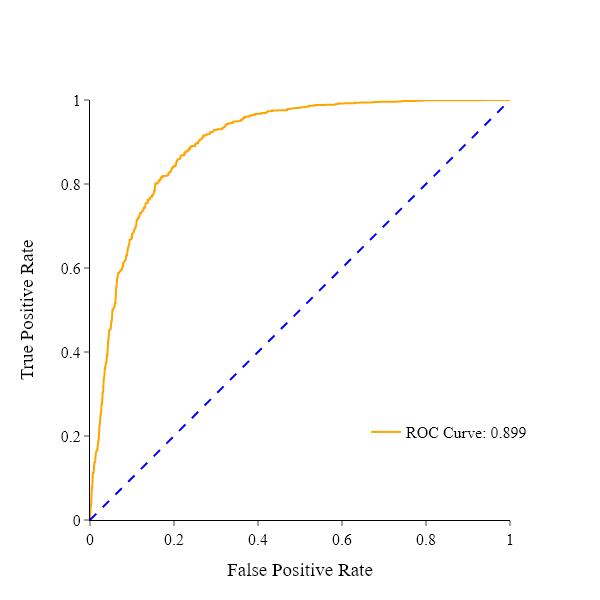

In [41]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=base_probabilities)

$\text{Final estimator: } estimator=DecisionTreeClassifier(max\_depth=1), \ n\_estimators=350, \ learning\_rate=1.0$

In [42]:
final_algorithm_optimized = AdaBoostClassifier(random_state=17, estimator=DecisionTreeClassifier(max_depth=1, random_state=17), n_estimators=350, learning_rate=1.0)
final_algorithm_optimized.fit(X_train, np.array(y_train).squeeze())
y_pred_final_optimized = final_algorithm_optimized.predict(X_test)
y_prob_final_optimized = final_algorithm_optimized.predict_proba(X_test)[:, 1]
print("Balance accuracy score: {}".format(np.round(balanced_accuracy_score(y_true=y_test, y_pred=y_pred_final_optimized), 5)))
print("Roc AUC score: {}".format(np.round(roc_auc_score(y_true=y_test, y_score=y_prob_final_optimized), 5)))
report = classification_report(y_test, y_pred_final_optimized, output_dict=True)
df = pd.DataFrame(report).transpose()
print(tabulate(df, headers="keys", tablefmt = 'psql'))

Balance accuracy score: 0.81952
Roc AUC score: 0.90179
+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
|--------------+-------------+----------+------------+-------------|
| 0.0          |    0.815526 | 0.844425 |   0.829724 | 1157        |
| 1.0          |    0.826087 | 0.79461  |   0.810043 | 1076        |
| accuracy     |    0.820421 | 0.820421 |   0.820421 |    0.820421 |
| macro avg    |    0.820806 | 0.819517 |   0.819883 | 2233        |
| weighted avg |    0.820615 | 0.820421 |   0.82024  | 2233        |
+--------------+-------------+----------+------------+-------------+


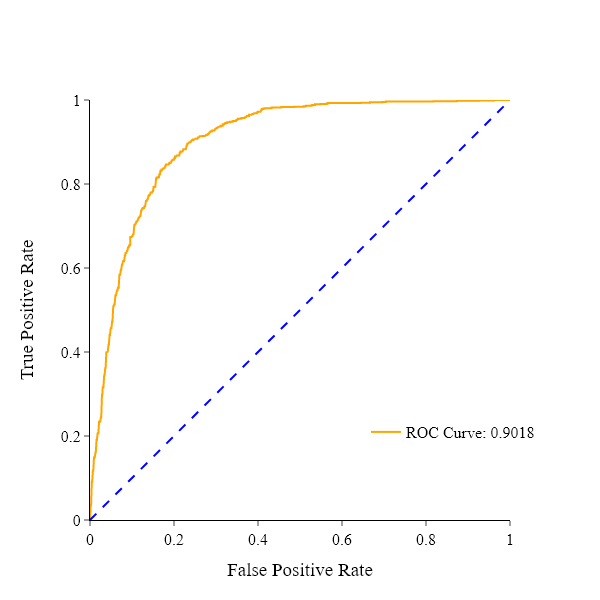

In [43]:
Plots_predictions.roc_auc_plot(y_true=y_test, y_prob=y_prob_final_optimized)

$\text{As we can see hyperparameter tuning have improved the effectiveness of the AdaBoost!}$

<h2>AdaBoost Regressor<h2>

<h1>Preprocessing<h1>

<h2>Download data<h2>

In [44]:
data = pd.read_csv("Data/Sales.csv")
X = data.drop("Sales", axis=1)
y = data["Sales"]

In [45]:
print("Number of observations in data: {}".format(len(data)))
data.head()

Number of observations in data: 4572


,TV,Radio,Social Media,Influencer,Sales
0,16.0,6.566231,2.907983,Mega,54.732757
1,13.0,9.237765,2.409567,Mega,46.677897
2,41.0,15.886446,2.913410,Mega,150.177829
3,83.0,30.020028,6.922304,Mega,298.246340
4,15.0,8.437408,1.405998,Micro,56.594181


<h2>Check for null data<h2>

In [46]:
data.isnull().sum()/len(data)

TV              0.002187
Radio           0.000875
Social Media    0.001312
Influencer      0.000000
Sales           0.001312
dtype: float64

In [47]:
data.dropna(inplace=True)

<h2>Convert object to numeric<h2>

In [48]:
list_of_object_features = data.select_dtypes(include="object").columns.tolist()
list_of_numeric_features = data.select_dtypes(exclude="object").columns.tolist()
encoder = OrdinalEncoder()
data[list_of_object_features] = encoder.fit_transform(data[list_of_object_features])

<h2>Divide our data into train and test sets<h2>

In [49]:
target_binary = "Sales"
X = data.drop(target_binary, axis=1)
y = data[[target_binary]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=17, test_size=0.2)

<h1>Evaluation and Visualization<h1>

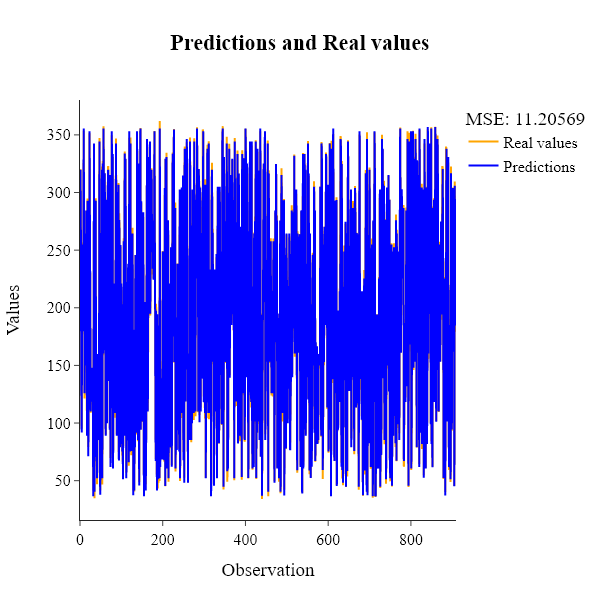

In [50]:
model = Ada_Boost_Regressor(n_estimators=50, learning_rate=1.0, loss="square", random_state=17)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Plots_predictions.compare_predictions_with_real_values(y_true=y_test, y_pred=y_pred, metric="MSE")

<h2>Features importance<h2>

$\text{As with the random forest, the significance of the variables will be based on the estimators from which Ensemble was built.}$<p>
$\text{In the case of AdaBoost, the weights assigned to each estimator must also be considered, so:}$
$$feature\_importnace_m=\frac{\sum_{t\in T}{\alpha_t\times f e a t u r e\_importnace}_{m,t}}{T}$$
$\text{Where: } T \text{ - the number of all estimators,}$<p>
$alpha_t \text{ - weight of estimator } t,$<p>
${feature_importnace}_{m,t} \text{ - significance of variable m for estimator }t.$

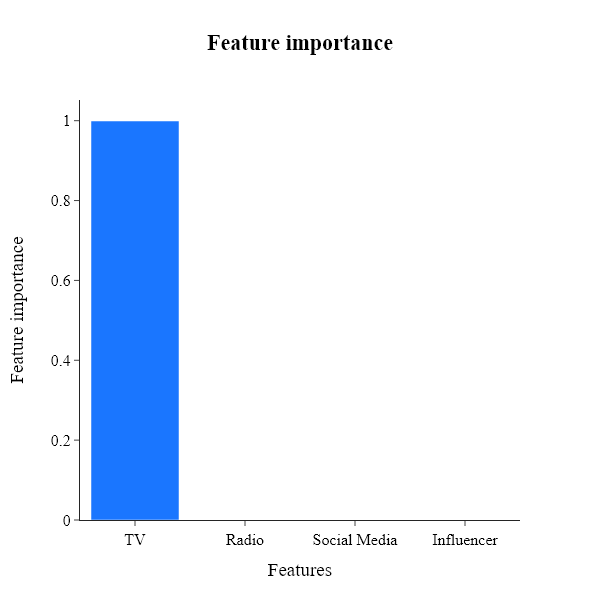

In [51]:
Plots_predictions.plot_feature_importances(feature_importances=list(model.normalized_feature_importances.values()), column_names=X.columns.tolist())

<h1>Comparision of AdaBoost to other boosting algorithms<h1>

$\text{The main difference between AdaBoost and the other popular boosting algorithms is that this algorithm uses residuals to determine the weights for each observation.}$<p>
$\text{In contrast, the other algorithms generally use residuals as the primary target.}$<p>
$\text{It is also slower than XGBoost.}$